In [2]:
%load_ext autoreload
%autoreload 2

# PriorVAE only: Scaling in n

In [3]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [4]:
from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt
from plotting.plots import plot_training,  plot_draws, plot_draws_hpdi
from flax.core.frozen_dict import freeze
from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE



rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


{'n': 100, 'gp_kernel': <function esq_kernel at 0x7f6835a175b0>, 'rng_key': Array([0, 2], dtype=uint32), 'x': Array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.09999999, 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.19999999, 0.21      , 0.22      , 0.22999999, 0.24      ,
       0.25      , 0.26      , 0.26999998, 0.28      , 0.29      ,
       0.29999998, 0.31      , 0.32      , 0.32999998, 0.34      ,
       0.35      , 0.35999998, 0.37      , 0.38      , 0.39      ,
       0.39999998, 0.41      , 0.42      , 0.42999998, 0.44      ,
       0.45      , 0.45999998, 0.47      , 0.48      , 0.48999998,
       0.5       , 0.51      , 0.52      , 0.53      , 0.53999996,
       0.55      , 0.56      , 0.57      , 0.58      , 0.59      ,
       0.59999996, 0.61      , 0.62      , 0.63      , 0.64      ,
       0.65      , 

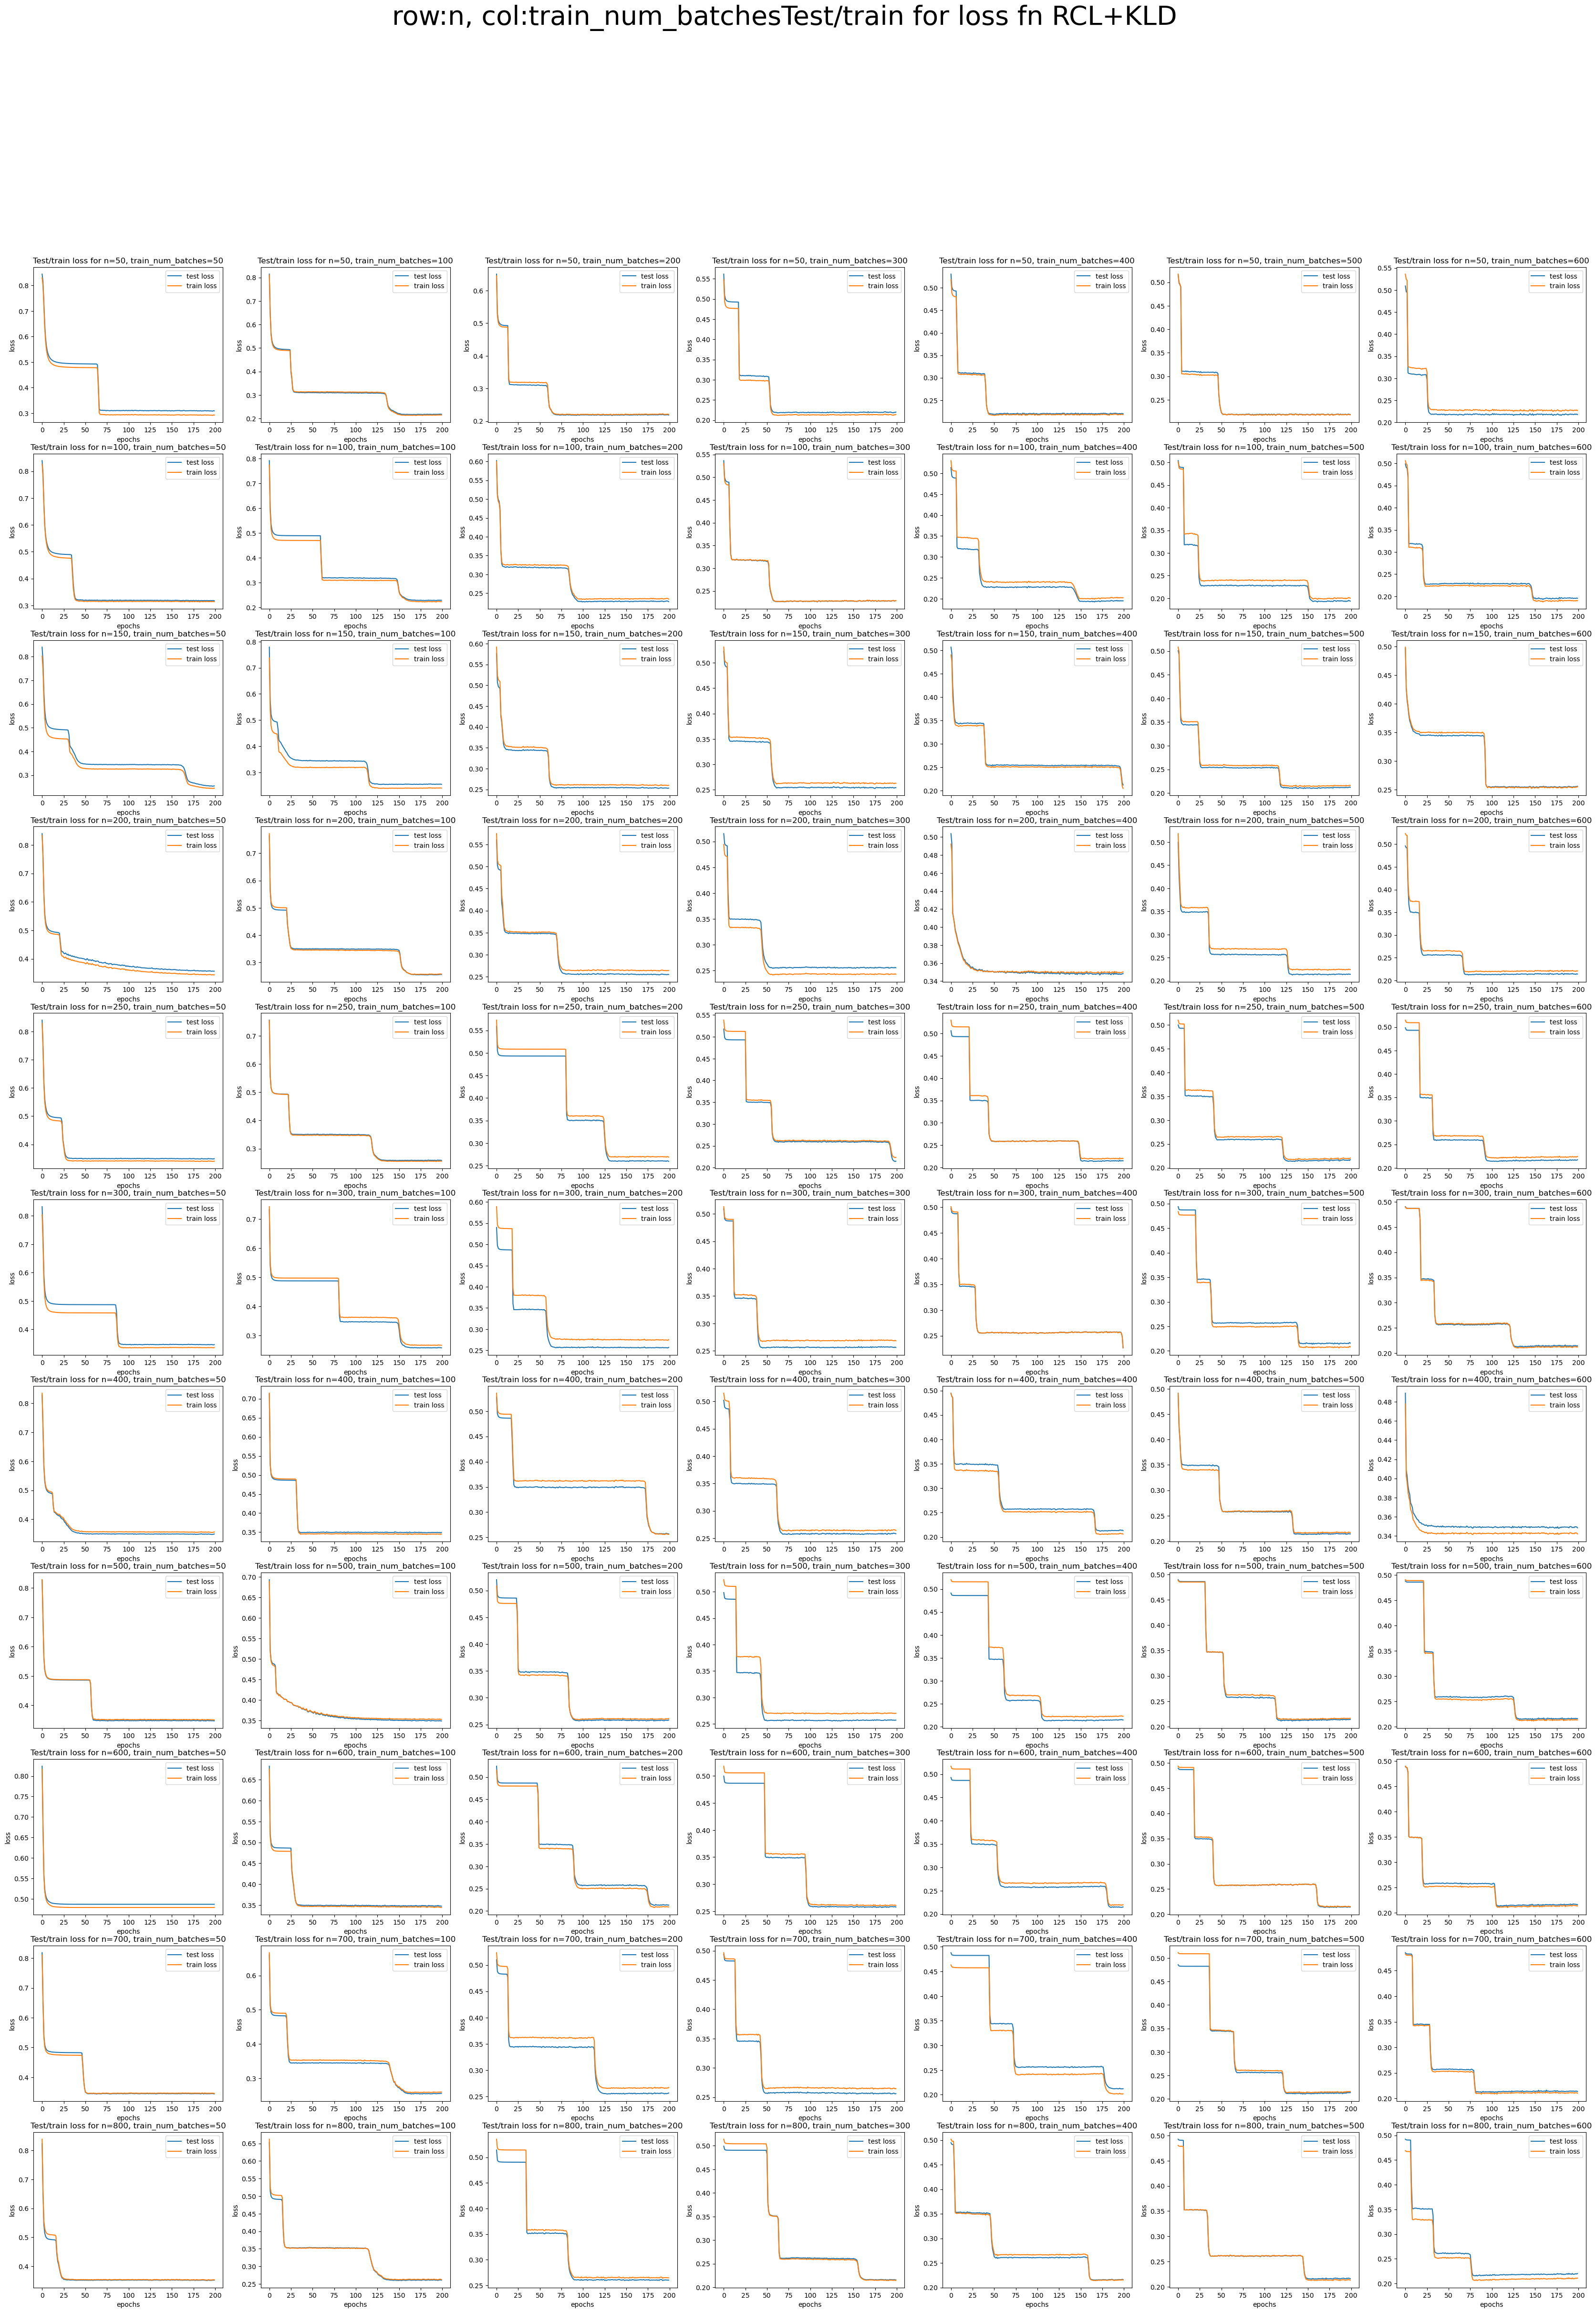

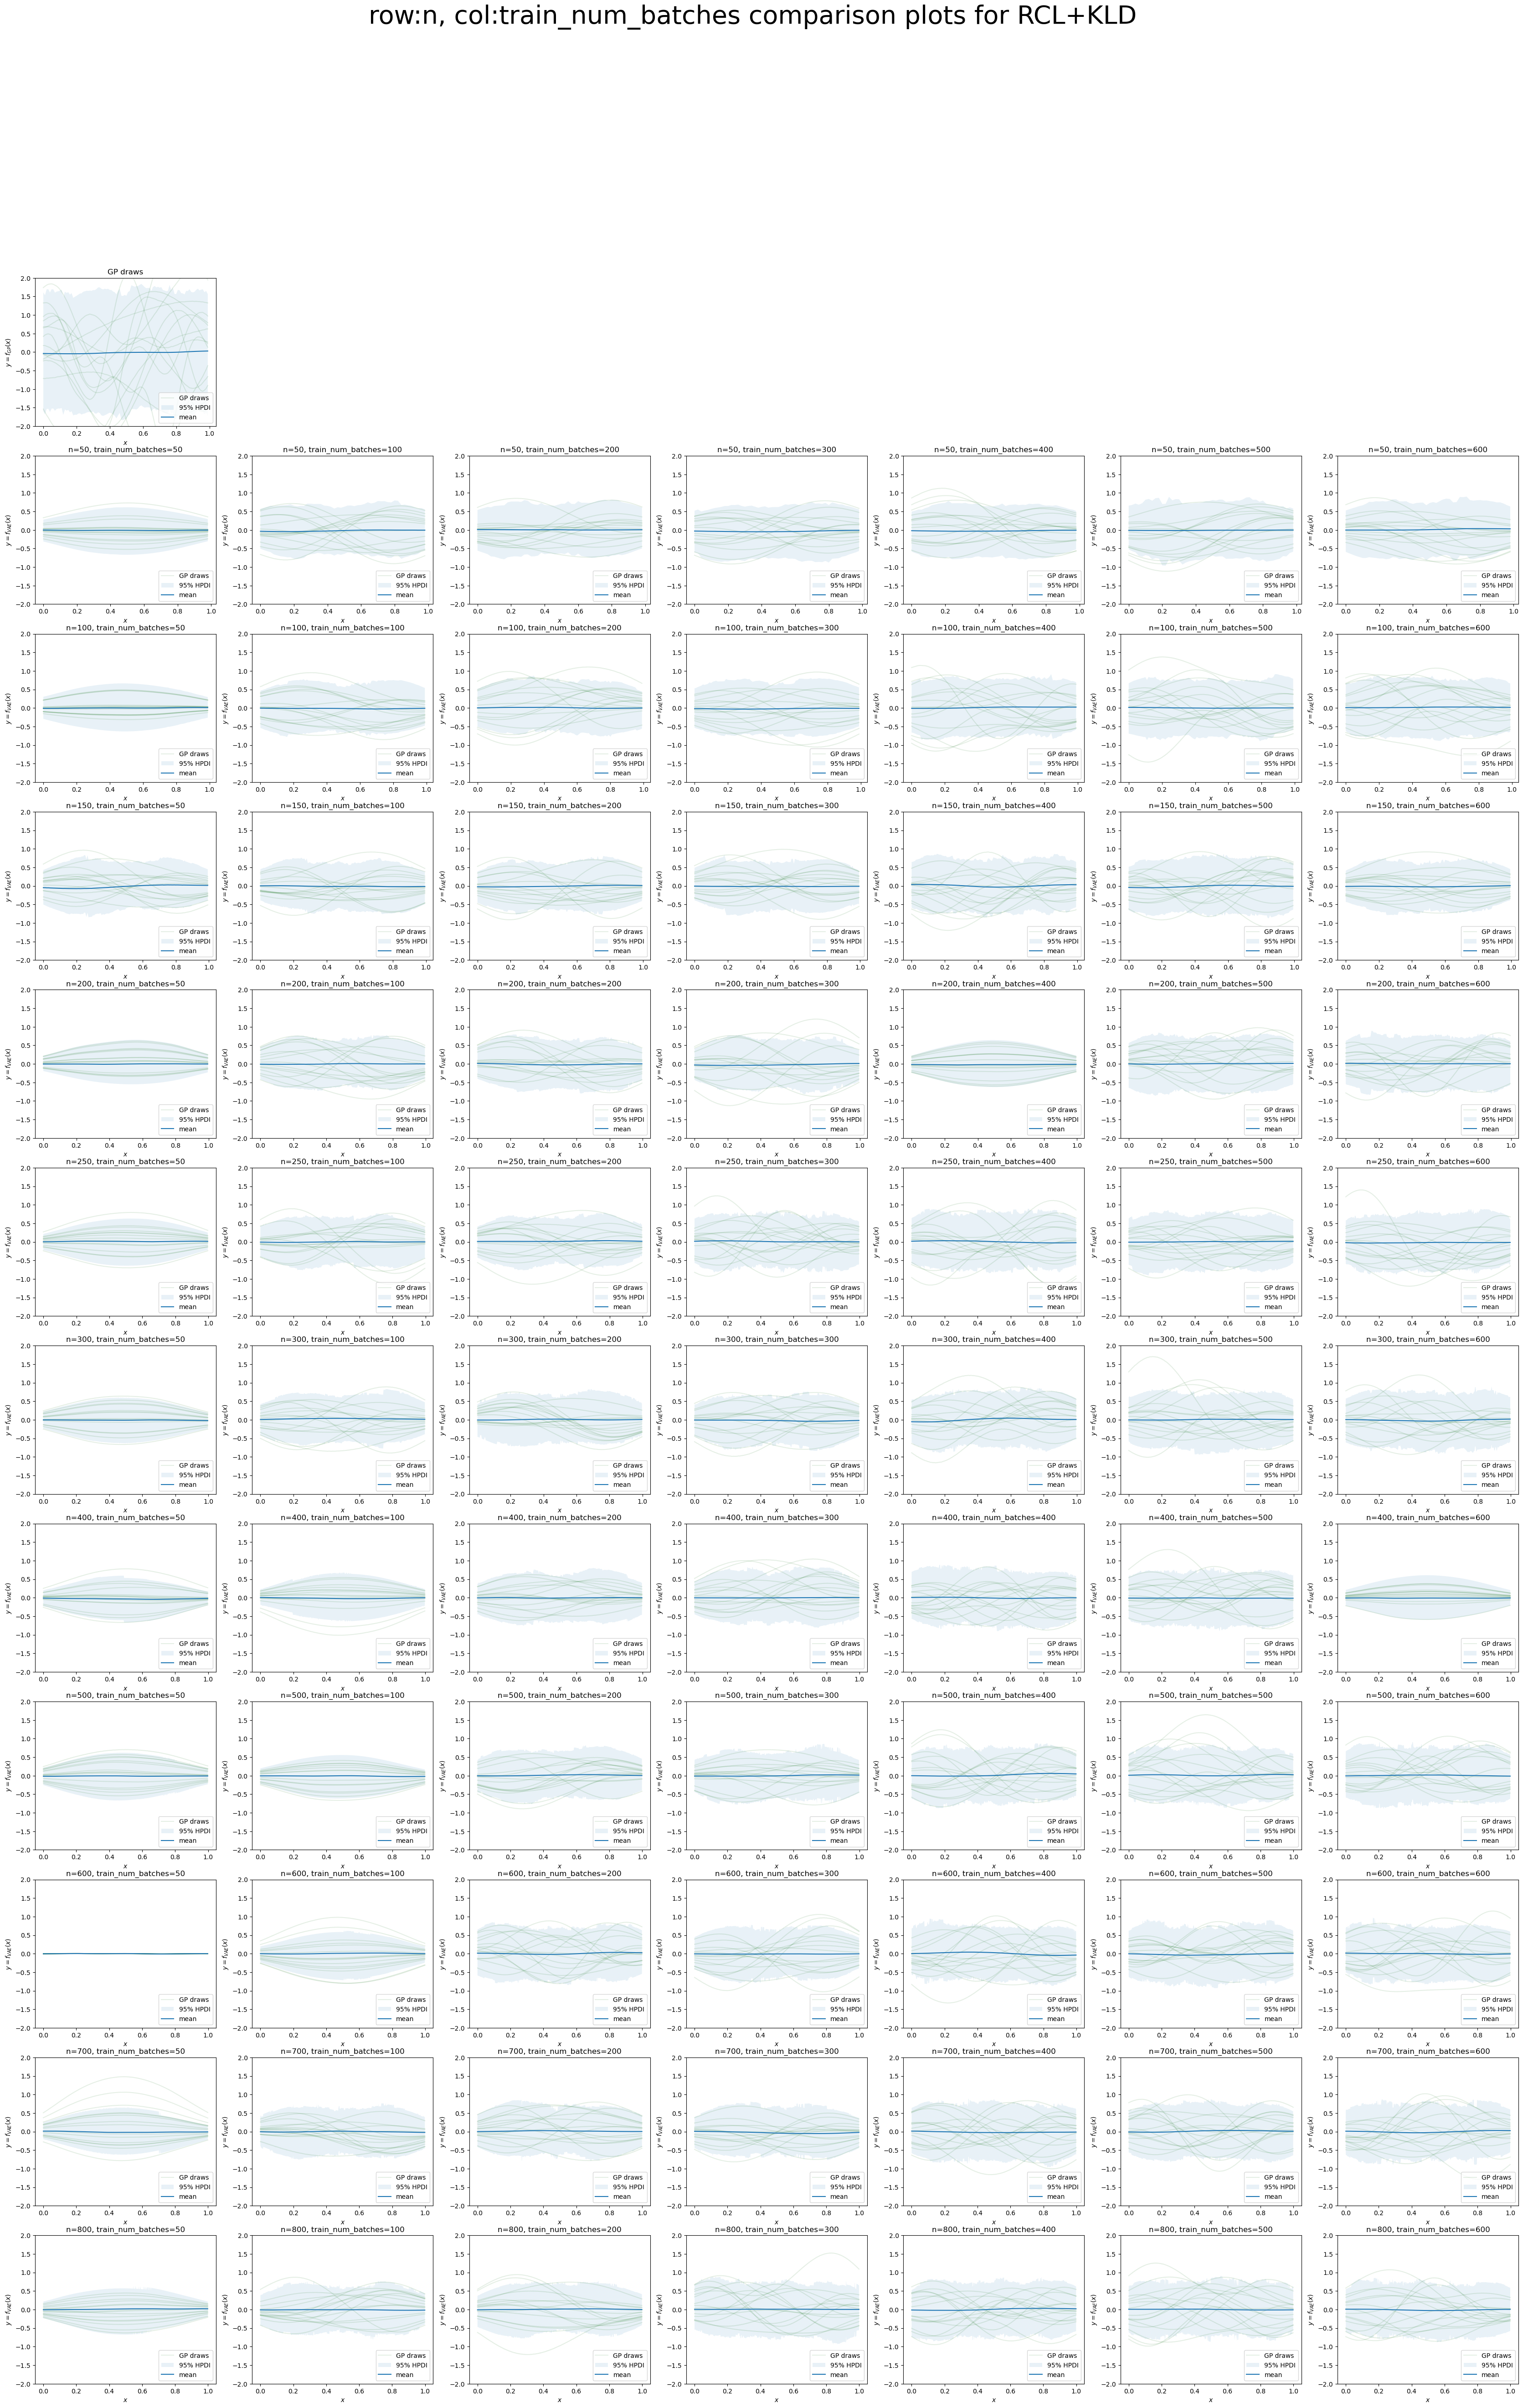

In [8]:
from reusable.util import update_args_11

with open(f"./learnt_models/13/13_args.dill", "rb") as f:
    exp_args = dill.load(f)

gp_draws = plot_gp_predictive(rng_key_gp, x=exp_args["x"], gp_kernel=exp_args["gp_kernel"], jitter=1e-5)["y"]

aL = len(exp_args["Arange"])
bL = len(exp_args["Brange"])

loss_fn = "RCL+KLD"


training_fig, training_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
training_fig.suptitle(
    f"row:{exp_args['Adesc']}, col:{exp_args['Bdesc']}Test/train for loss fn {loss_fn}",
    fontsize=40,
)

comp_fig, comp_axs = plt.subplots(nrows=aL + 1, ncols=bL, figsize=(bL * 6, aL * 5 + 5))
comp_fig.suptitle(
    f"row:{exp_args['Adesc']}, col:{exp_args['Bdesc']} comparison plots for {loss_fn}",
    fontsize=40,
)

plot_draws_hpdi(gp_draws, exp_args["x"], f"GP draws", "$y=f_{GP}(x)$", ax=comp_axs[0, 0])

for j in range(1, len(exp_args["Brange"])):
    comp_axs[0, j].remove()

for i, a in enumerate(exp_args["Arange"]):
    for j, b in enumerate(exp_args["Brange"]):
        with open(f"./learnt_models/13/13_args.dill", "rb") as f:
            # so we get a new copy for each one!
            args = dill.load(f)

        args = update_args_11(args, args, i, j)

        index = i + j * aL
        name = f"{loss_fn}_13_{index}"
        file_path = f'{get_savepath()}/{decoder_filename("13/13", args, suffix=name)}'

        try:
            with open(file_path + "_metrics_hist", "rb") as file:
                metrics_history = dill.load(file)

            plot_training(
                metrics_history["test_loss"],
                metrics_history["train_loss"],
                f"Test/train loss for {exp_args['Adesc']}={a}, {exp_args['Bdesc']}={b}",
                "loss",
                training_axs[i, j],
            )

            dummy = VAE(
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                conditional=False,
            )
            dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

            with open(file_path, "rb") as file:
                bytes = file.read()
                # serialization.to_bytes(freeze({"params": final_state.params["VAE_Decoder_0"]})))
                # new_dummy  =  freeze({"params" : dummy_params})
                new_state = serialization.from_bytes(dummy_params, bytes)
                args["decoder_params"] = freeze({"params": new_state["params"]["VAE_Decoder_0"]})

            plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            plot_draws_hpdi(
                vae_draws,
                args["x"],
                f"{exp_args['Adesc']}={a}, {exp_args['Bdesc']}={b}",
                "$y=f_{VAE}(x)$",
                ax=comp_axs[i + 1, j],
            )

        except FileNotFoundError:
            print(f"Failed to load a={a}, b={b}, path = {file_path}")


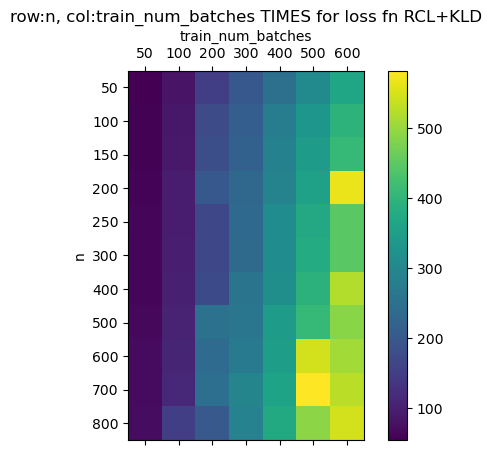

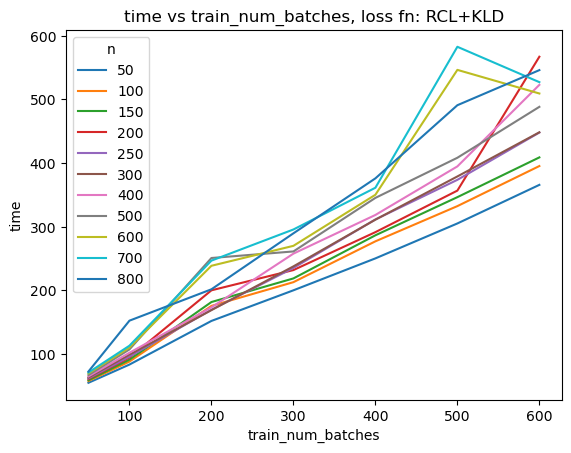

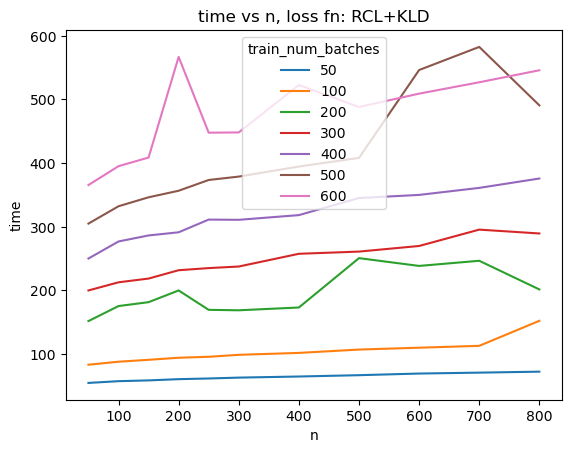

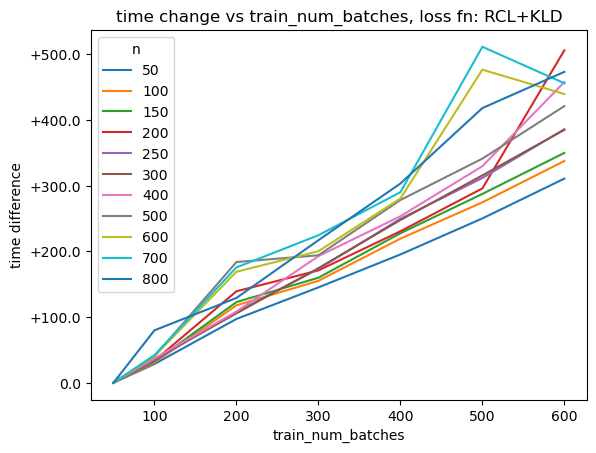

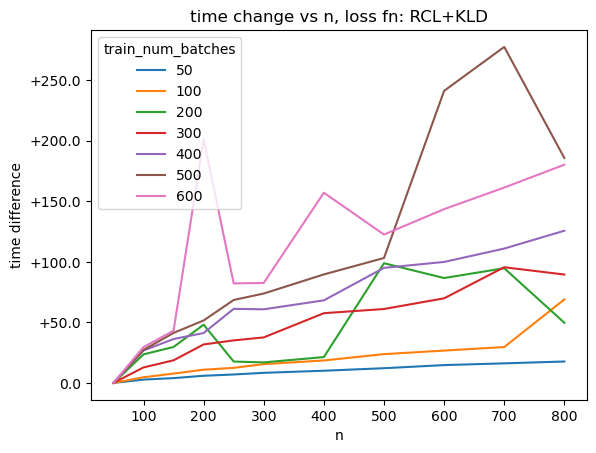

In [11]:
import numpy as onp
from plotting.plots import plot_times_matrix, plot_times_graph


def correct_timing(history, prev_hists):
    """Issue: epoch (and batch times), reset every so often, as I didn't add the times up when rerunning the training"""
    if len(prev_hists) == 0:
        return history

    history["epoch_times"] = history["epoch_times"] + prev_hists[-1]["epoch_times"][-1]
    history["batch_times"] = history["batch_times"] + prev_hists[-1]["epoch_times"][-1]

    return history


with open(f"./learnt_models/13/13_args.dill", "rb") as f:
    temp_args = dill.load(f)

exp_args = temp_args
aL = len(exp_args["Arange"])
bL = len(exp_args["Brange"])

loss_fn = "RCL+KLD"
histories = []

# time_fig, time_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
# time_fig.suptitle(
#     f"{experiment}: row:{exp_args['Adesc']}, col:{exp_args['Bdesc']} TIMES for loss fn {loss_fn}", fontsize=40
# )

for i, a in enumerate(exp_args["Arange"]):
    i_hists = []
    for j, b in enumerate(exp_args["Brange"]):
        with open(f"./learnt_models/13/13_args.dill", "rb") as f:
            # so we get a new copy for each one!
            args = dill.load(f)

        args = update_args_11(args, args, i, j)

        index = i + j * aL
       
        name = f"{loss_fn}_13_{index}"
     
        file_path = f'{get_savepath()}/{decoder_filename("13/13", args, suffix=name)}'

        try:
            with open(file_path + "_metrics_hist", "rb") as file:
                h = dill.load(file)
            
                i_hists.append(h)

        except FileNotFoundError:
            i_hists.append({"interrupted": True})
            print(f"Failed to load a={a}, b={b}, path = {file_path}")
    histories.append(i_hists)
    
full_times = onp.array([[h["epoch_times"][-1] if "epoch_times" in h else float('nan') for h in hs] for hs in histories])

interrupted = onp.array([["interrupted" in h for h in hs] for hs in histories])
full_epochs = onp.array([[len(h["epoch_times"])if "epoch_times" in h else float('nan') for h in hs] for hs in histories])
# matrix of A x B, showing times
plot_times_matrix(
    full_times,
    interrupted,
    exp_args["Arange"],
    exp_args["Brange"],
    exp_args["Adesc"],
    exp_args["Bdesc"],
    f"row:{exp_args['Adesc']}, col:{exp_args['Bdesc']} TIMES for loss fn {loss_fn}",
    save_path=f"./gen_plots/13/13_{loss_fn}_matrix.png",
)
# graph of x=A, y=time, curve per B

plot_times_graph(
    full_times,
    exp_args["Brange"],
    exp_args["Arange"],
    exp_args["Bdesc"],
    exp_args["Adesc"],
    f"time vs {exp_args['Bdesc']}, loss fn: {loss_fn}",
    save_path=f"./gen_plots/13/13_{loss_fn}_timeVb.png",
)
# graph of x=B, y=time, curve per B
plot_times_graph(
    full_times.T,
    exp_args["Arange"],
    exp_args["Brange"],
    exp_args["Adesc"],
    exp_args["Bdesc"],
    f"time vs {exp_args['Adesc']}, loss fn: {loss_fn}",
    save_path=f"./gen_plots/13/13_{loss_fn}_timeVa.png",
)

# same graphs, but just increase from initial:
initial_times = full_times[:, 0][:, jnp.newaxis]
initial_times = jnp.tile(initial_times, (1, full_times.shape[1]))

plot_times_graph(
    full_times - initial_times,
    exp_args["Brange"],
    exp_args["Arange"],
    exp_args["Bdesc"],
    exp_args["Adesc"],
    f"time change vs {exp_args['Bdesc']}, loss fn: {loss_fn}",
    is_relative=True,
    save_path=f"./gen_plots/13/13_{loss_fn}_timeVb_change.png",
)

initial_times = full_times.T[:, 0][:, jnp.newaxis]
initial_times = jnp.tile(initial_times, (1, full_times.shape[0]))
# graph of x=B, y=time, curve per B
plot_times_graph(
    full_times.T - initial_times,
    exp_args["Arange"],
    exp_args["Brange"],
    exp_args["Adesc"],
    exp_args["Bdesc"],
    f"time change vs {exp_args['Adesc']}, loss fn: {loss_fn}",
    is_relative=True,
    save_path=f"./gen_plots/13/13_{loss_fn}_timeVa_change.png",
)
